In [1]:
from bs4 import BeautifulSoup
import requests

#from selenium import webdriver

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib
#from matplotlib import rcParams
matplotlib.use('tkAgg', force=True)
from matplotlib.lines import Line2D

import seaborn as sns
import collections

import pandas as pd
import numpy as np
    
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use('seaborn-poster')

In [2]:
base_url = 'https://beta7.app/'

In [3]:
#font_manager.fontManager.ttflist

In [4]:
attempts = ['⚡', '🥈', '👊', '❓', '✔️']
attempts
#'\U0001f948' second place

['⚡', '🥈', '👊', '❓', '✔️']

In [5]:
# user_url = 'https://beta7.app/user/bellonet'
# user_page = requests.get(user_url)
# soup_user = BeautifulSoup(user_page.text, 'html.parser')

In [6]:
grade_colors = collections.OrderedDict()

grade_colors['4'] = '#fcff33'
grade_colors['5'] = '#58ff33'
grade_colors['6A'] = '#9df7f2'
grade_colors['6A+'] = '#1cacb2'
grade_colors['6B'] = '#207ea7'
grade_colors['6B+'] = '#b58de8'
grade_colors['6C'] = '#9a57a2'
grade_colors['6C+'] = '#9a23a8'
grade_colors['7A'] = '#909090'
grade_colors['7A+'] = '#616161'
grade_colors['7B'] = '#424141'
grade_colors['7B+'] = '#303030'
grade_colors['7C'] = '#000000'


# ### Beta7 grade colors - hard to distinguish:
# grade_colors['4'] = '#e8da00'
# grade_colors['5'] = '#00a476'
# grade_colors['6A'] = '#199a92'
# grade_colors['6A+'] = '#008db2'
# grade_colors['6B'] = '#1684ae'
# grade_colors['6B+'] = '#6d5e9c'
# grade_colors['6C'] = '#835498'
# grade_colors['6C+'] = '#914e95'
# grade_colors['7A'] = '#453152'
# grade_colors['7A+'] = '#382a44'
# grade_colors['7B'] = '#282132'
# grade_colors['7B+'] = '#12151a'
# grade_colors['7C'] = '#36101f'

In [7]:
## NOT USED - CURRENTLY NO HEIGHT AS HUE
# ## our min height - 158, max - 199  (starting a bit before min to not have white)
# minh = 156
# rang = 44

# cmap_discr = sns.color_palette("vlag", as_cmap=True)(np.linspace(0, 1, rang)) #red to blue
# cmap_discr = sns.color_palette("Blues", as_cmap=True)(np.linspace(0, 1, rang))

# height_colors = {i+minh:c for i,c in enumerate(cmap_discr)}
# height_colors[0] = np.array([0.5, 0.5, 0.5, 1.])

In [8]:
attempt_colors_hex = ['#009e73', '#f0e442', '#CC79A7', '#a39f9e', '#080808']

attempt_colors = {'⚡':attempt_colors_hex[0],
                  '🥈':attempt_colors_hex[1],
                  '👊':attempt_colors_hex[2],
                  '❓':attempt_colors_hex[3],
                  '✔️':attempt_colors_hex[4]}

# attempt_markers = {'⚡':'$⚡$',
#                   '🥈':'$🥈$',
#                   '👊':'$👊$',
#                   '❓':'$❓$',
#                   '✔️':'$✔️$'}

#### Get some route links:

In [9]:
# url = base_url + "location/bertablock/routes"
# routes_page = requests.get(url)

In [10]:
# soup = BeautifulSoup(routes_page.text, 'html.parser')

In [11]:
# routes_hrefs = [a['href'] for a in soup.find_all('a', href=True) if 'route/' in a['href']]
# routes_hrefs, len(routes_hrefs)

#### Route links by sector:

In [12]:
sectors = ['Solarium', 'Enterprise', 'Dicke Berta', 'Submarino', 'Jumbo Love', 'Ekcürb', 'UFO']

routes_hrefs = [
    ## solarium
    'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1661788912500', #blue
    'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1661789017690', #purple
    'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1661788937882', #black
    ## enterprise
    'route/UQGtEzKKf7NHJM6JGCdYL8LrkPl2~1662479556933',
    'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1662389432443',
    'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1662389381474',
    ## dicke berta
    'route/UQGtEzKKf7NHJM6JGCdYL8LrkPl2~1658761877810',
    'route/DVRZplVT6uZlilfjDrKkk343txO2~1658763312831',
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1658762210519',
    ## submarino
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1662477304908',
    'route/hBuhKAxUX6PwJ5gi2rxqN7n8eeR2~1662478024076',
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1658762210519',
    ## jumbo love
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1658156156151',
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1653051975825',
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1653052038044',
#     ## ekcürb
    'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1660575179166',
    'route/UQGtEzKKf7NHJM6JGCdYL8LrkPl2~1657038770580',
    'route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1660575342837',
    ## ufo
    'route/GSUDMcdZRbeDWEst1PLzaeJTfhg1~1660574616822',
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1660574470641',
    'route/jzquGG3GoYgvvQzFrKXnzvecLwm2~1660574628259'
]


#### Play with an example route

In [13]:
# route_page = requests.get('https://beta7.app/route/f4nckAL9eSMtxGyPOBpMPC5Rant1~1658156305618')

# soup_route = BeautifulSoup(route_page.text)

In [14]:
# try:
#     route_name = soup_route.select_one('.route-name').text
# except:
#     route_name = 'XXX'
    
# route_name

In [15]:
# route_level = soup_route.select_one('.fb').text
# route_level

In [16]:
# route_senders = [t for t in soup_route.select(".climb-container") 
#                  if "<span>made a beta request</span>" not in str(t)]
# len(route_senders)

In [17]:
# route_heights = [int(s.select_one(".height").text[:-2]) if s.select_one(".height") else None 
#                  for s in route_senders]
# route_heights[0], len(route_heights)

In [18]:
# route_levels = [s.select_one(".level").text[1:] if s.select_one(".level") else None 
#                  for s in route_senders]
# route_levels[5], len(route_levels)

In [19]:
# route_sendtype = [s.select_one(".sending-type").text if s.select_one(".sending-type") else None 
#                   for s in route_senders]

# route_sendtype[route_sendtype==None] = '??'

# len(route_sendtype)

### Plot multiple routes

In [20]:
routes_page = [requests.get(base_url + r) for r in routes_hrefs]

In [21]:
a = BeautifulSoup(routes_page[3].text)
route_senders = [t for t in a.select(".climb-container") 
         if "<span>made a beta request</span>" not in str(t)]

In [22]:
df = pd.DataFrame()

for i in range(len(routes_hrefs)):

    unique_route_index = i

    # entire page text:
    soup_route = BeautifulSoup(routes_page[i].text)

    # Get route name - if exists
    try:
        route_name = soup_route.select_one('.route-name').text
    except:
        route_name = 'XXX'

    # Get route level: 
    route_level = soup_route.select_one('.fb').text.split('/')

    # Get hold color:
    hold_color = soup_route.select('.color')[1].text.strip()
    if hold_color=='forest':
        hold_color = '#014421'
    elif hold_color in ['lemon','yellow']:
        hold_color = '#FFEA00'
    elif hold_color=='cornflower':
        hold_color='#9aceeb'
    #hold_color = soup_route.find('title').text.split(' ')[0]

    # List of climbers - full text per climber
    route_senders = [t for t in soup_route.select(".climb-container") 
             if "<span>made a beta request</span>" not in str(t)]
    
    # Their height
    route_heights = [int(s.select_one(".height").text[:-2]) if s.select_one(".height") else np.nan 
             for s in route_senders]

    # Their level
    route_levels = [s.select_one(".level").text[1:] if s.select_one(".level") else None 
         for s in route_senders]

    # Their number of attemps
    route_sendtype = [s.select_one(".sending-type").text if s.select_one(".sending-type") else '❓' 
              for s in route_senders]

    # Create the df
    df_route = pd.DataFrame({"height":route_heights, "levels":route_levels, 'sendtype':route_sendtype})
    df_route['idx'] = i
    df_route['name'] = route_name
    df_route['level'] = route_level[0]
    df_route['gym_level'] = route_level[1]
    df_route['hold_color'] = hold_color
    
    df = pd.concat([df, df_route])

df = df.reset_index(drop=True)
df.shape

(701, 8)

In [23]:
df.sendtype.unique()

array(['⚡', '🥈', '👊', '❓', '✔️', '🎫'], dtype=object)

In [24]:
df = df.drop(df[df.sendtype == '🎫'].index)

df.shape, df.sendtype.unique()

((648, 8), array(['⚡', '🥈', '👊', '❓', '✔️'], dtype=object))

In [25]:
df = df.reset_index(drop=True)

In [26]:
df.groupby(['idx','level']).agg({'height':["mean","median","min","max"]}).sort_values(by=['level'])

height                     
                 mean median    min    max
idx level                                 
0   6A     175.586667  176.0  158.0  199.0
3   6A     174.615385  173.0  158.0  194.0
18  6B     175.111111  177.0  159.0  191.0
6   6B     175.900000  176.0  162.0  194.0
15  6B     173.729730  174.0  159.0  194.0
9   6B     176.763158  177.0  162.0  199.0
12  6B     177.634146  179.0  160.0  194.0
1   6C     179.000000  179.5  162.0  187.0
4   6C     176.333333  175.5  166.0  187.0
16  6C     180.812500  181.0  163.0  199.0
7   6C     177.458333  179.5  165.0  188.0
19  6C     175.307692  177.0  158.0  190.0
13  6C+    178.853659  179.0  162.0  193.0
10  6C+    179.285714  179.0  174.0  187.0
20  7A     176.500000  178.0  158.0  191.0
8   7A+    178.500000  178.0  166.0  186.0
2   7A+    179.000000  179.0  168.0  187.0
11  7A+    178.500000  178.0  166.0  186.0
14  7B     179.625000  180.5  172.0  187.0
5   7B     175.666667  176.0  173.0  178.0
17  7B     176.000000  176.0  176.0  176.0

In [27]:
df[df.idx==17]

,height,levels,sendtype,idx,name,level,gym_level,hold_color
525,176.0,7C,🥈,17,Industrietackerei,7B,SCHWARZ,#FFEA00


#### X attempts, Y height, Hue sender grade

/home/ella/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ella/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


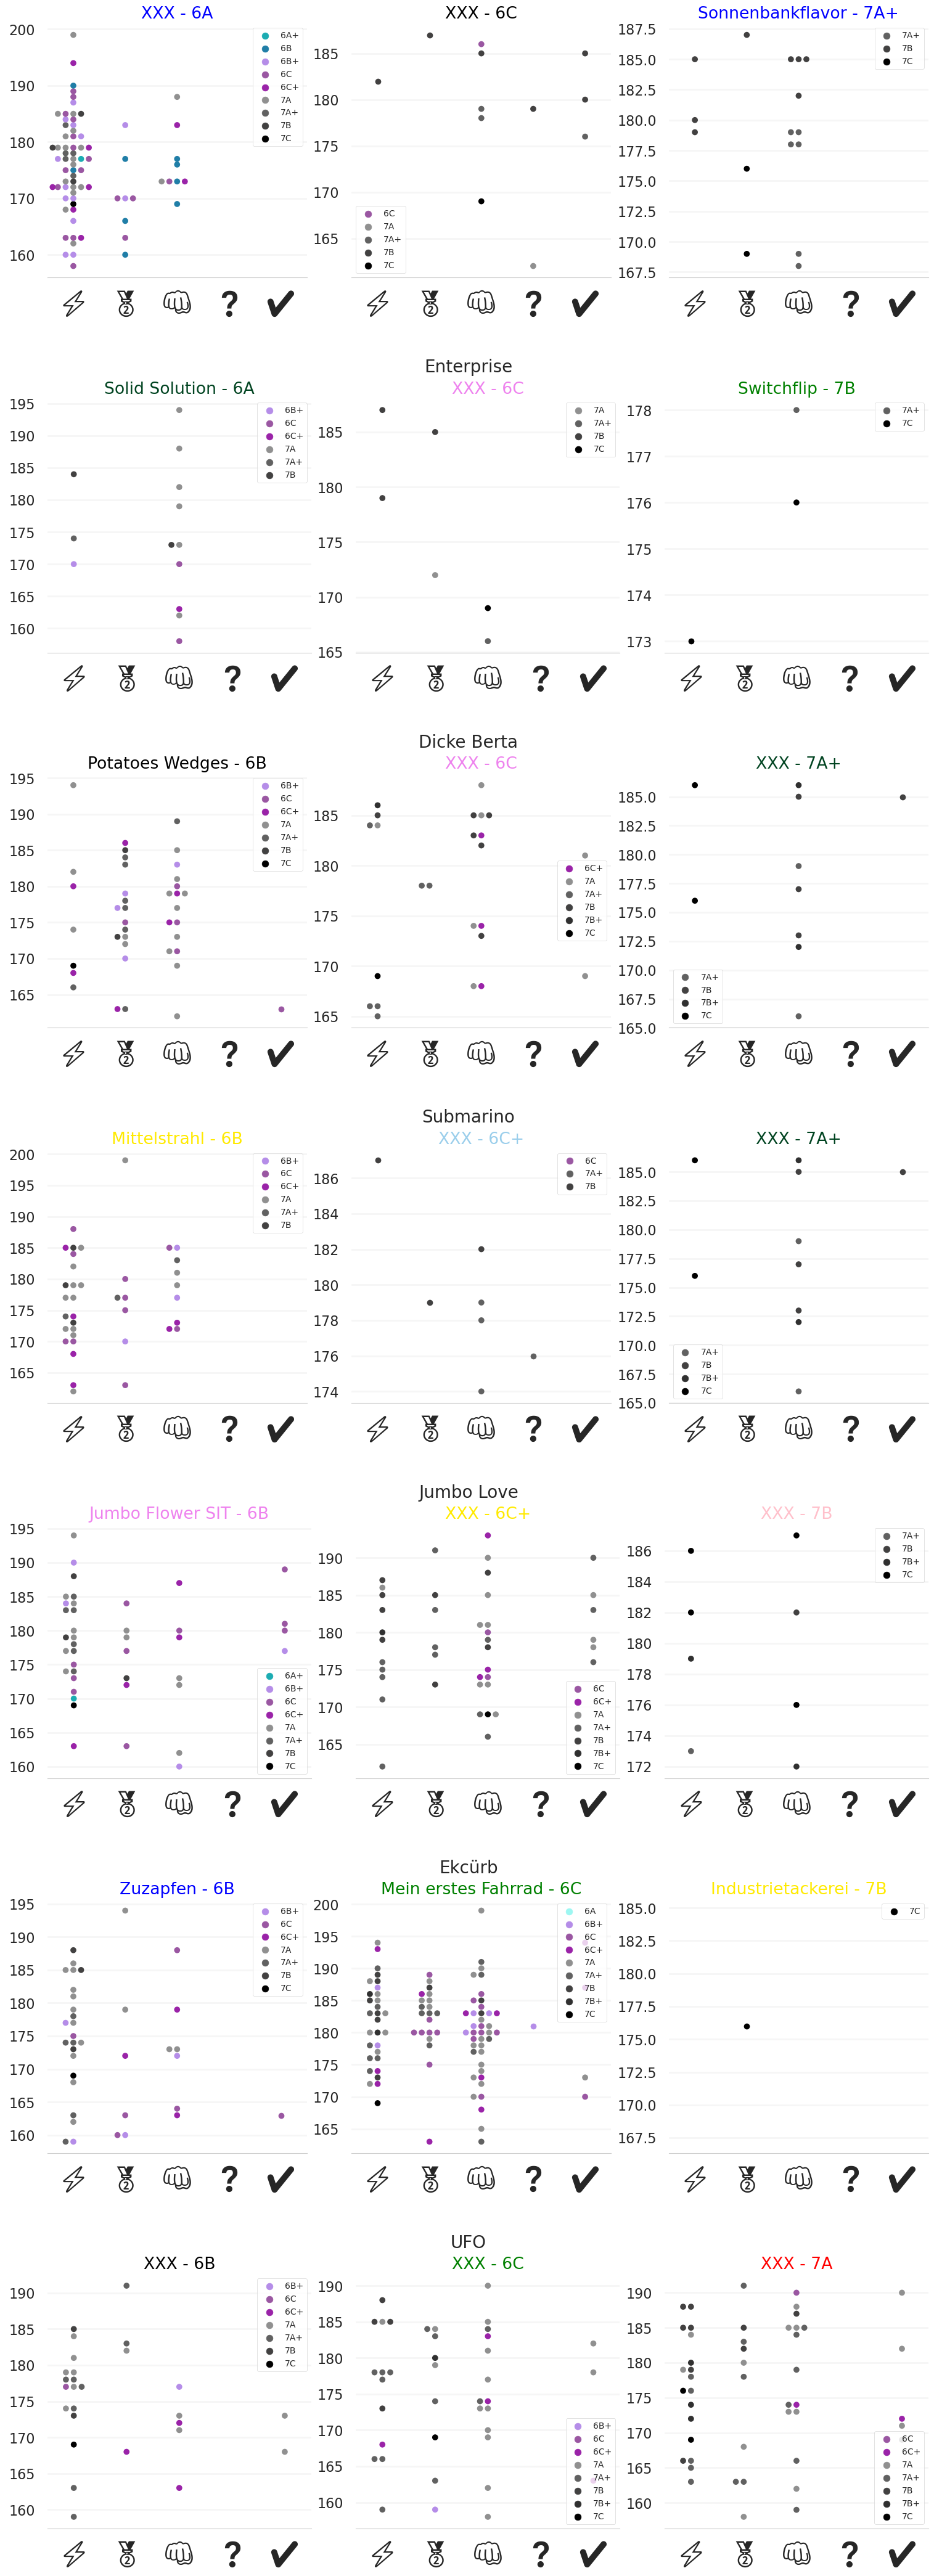

In [28]:
nrows,ncols = len(routes_hrefs)//3,3

#fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

fig = plt.figure(constrained_layout=True, figsize=(5*ncols,6*nrows))

## create nrows subfigs
subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

for i,subfig in enumerate(subfigs):
        
        subfig.suptitle(sectors[i], fontsize=20)
        
        # create 1xncols subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=ncols)
        for j, ax in enumerate(axs):

            df_route = df[df.idx == i*ncols+j]
            df_route = df_route.sort_values(by=["levels"])

            sns.swarmplot(data=df_route, x=df_route.sendtype, y=df_route.height, order=attempts, 
                          hue=df_route.levels, palette=grade_colors, ax=axs[j], size=7)

            axs[j].set_xticklabels(attempts, fontsize=30, fontproperties={'family':'Noto Emoji', 'weight':'bold'})
            axs[j].legend(fontsize=10, numpoints=1.5)            
            axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
                             color=df_route.hold_color.iat[0])
            axs[j].set_xlabel('')
            axs[j].set_ylabel('')
            axs[j].grid(color='#f6f6f6', linestyle='-', linewidth=2, axis='y')
            sns.despine(left=True)

plt.savefig('xAttempts_yHeight_hueLevel.png')

#### X height , Y attempts, Hue sender grade

/home/ella/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ella/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


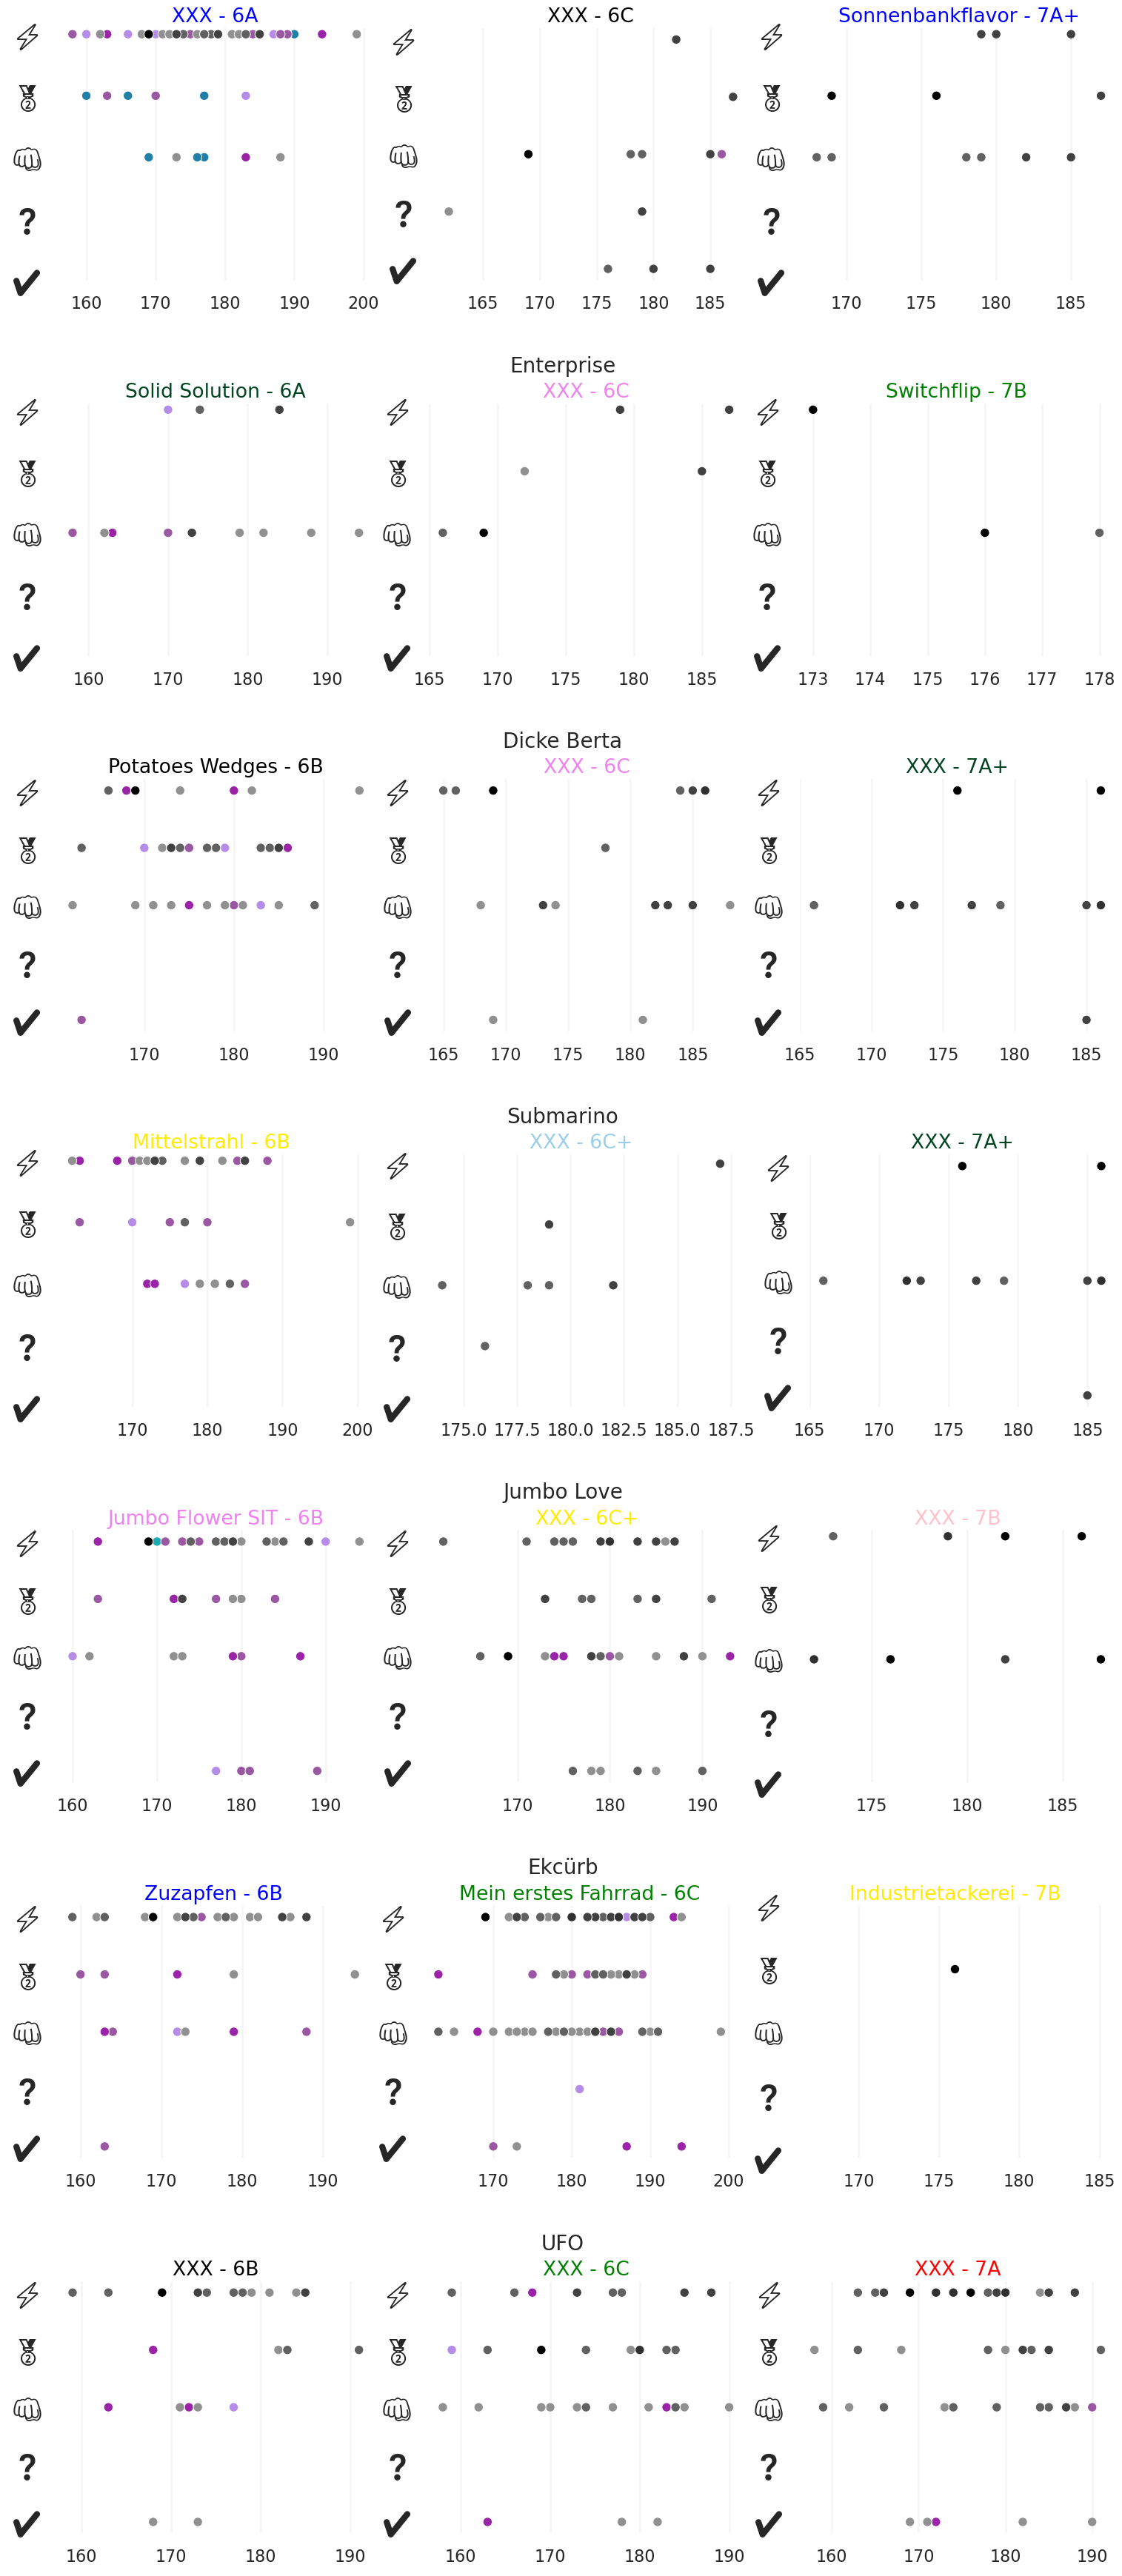

In [29]:
nrows,ncols = len(routes_hrefs)//3,3

#fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

fig = plt.figure(constrained_layout=True, figsize=(5*ncols,5*nrows))

## create nrows subfigs
subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

for i,subfig in enumerate(subfigs):
        
        subfig.suptitle(sectors[i], fontsize=20)
        
        # create 1xncols subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=ncols)
        for j, ax in enumerate(axs):

            df_route = df[df.idx == i*ncols+j]
            df_route = df_route.sort_values(by=["levels"])
            df_route.sendtype = pd.Categorical(df_route.sendtype, 
                      categories=attempts,
                      ordered=True)

            sns.scatterplot(data=df_route, x=df_route.height, y=df_route.sendtype, 
                          hue=df_route.levels, palette=grade_colors, ax=axs[j], s=80)

            axs[j].set_yticks(attempts)
            axs[j].set_yticklabels(attempts, fontsize=25, fontproperties={'family':'Noto Emoji', 'weight':'bold'})

            ## Needed because of a bug of an extra legend item
            leg = axs[j].get_legend_handles_labels()
            axs[j].legend(leg[0][:-1],leg[1][:-1], fontsize=10, numpoints=1.5)            
            axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
                             color=df_route.hold_color.iat[0])
            axs[j].set_xlabel('')
            axs[j].set_ylabel('')
            sns.despine(left=True, bottom=True)
            axs[j].legend([],[], frameon=False)
            axs[j].grid(False)
            axs[j].grid(color='#f6f6f6', linestyle='-', linewidth=2, axis='x')
            
plt.savefig('xheight_yAttempts_hueLevel.png')

#### X attempts, Y sender grade, Hue height

In [30]:
## CREATES MARKERS THAT ARE TOO SMALL
# nrows,ncols = len(routes_hrefs)//3,3

# #fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

# fig = plt.figure(constrained_layout=True, figsize=(5*ncols,6*nrows))

# ## create nrows subfigs
# subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

# for i,subfig in enumerate(subfigs):
        
#         subfig.suptitle(sectors[i], fontsize=20)
        
#         # create 1xncols subplots per subfig
#         axs = subfig.subplots(nrows=1, ncols=ncols)
#         for j, ax in enumerate(axs):

#             df_route = df[df.idx == i*ncols+j]
#             df_route = df_route.sort_values(by=["levels"])
#             df_route['height'] = df_route['height'].fillna(0)
#             df_route = df_route.astype({"height": int})

#             sns.swarmplot(data=df_route, x=df_route.sendtype, y=df_route.levels, order=attempts, 
#                           hue=df_route.height, palette=height_colors, ax=axs[j], size=6, marker="*")

#             axs[j].set_xticklabels(attempts, fontsize=30, fontproperties={'family':'Noto Emoji', 'weight':'bold'})
            
#             legend_elements = [Line2D([0], [0], marker='o', color=height_colors[0], label='-'),
#                                Line2D([0], [0], marker='o', color='w', label='Scatter', markersize=15)]
            
            
#             axs[j].legend(handles=legend_elements, fontsize=10, numpoints=1.5)            
#             axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
#                              color=df_route.hold_color.iat[0])
#             axs[j].set_xlabel('')
#             axs[j].set_ylabel('')
#             sns.despine(left=True)

#### X sender grade, Y attemps, Hue height

In [31]:
## CREATES MARKERS THAT ARE TOO SMALL
# nrows,ncols = len(routes_hrefs)//3,3

# #fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

# fig = plt.figure(constrained_layout=True, figsize=(5*ncols,5*nrows))

# ## create nrows subfigs
# subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

# for i,subfig in enumerate(subfigs):
        
#         subfig.suptitle(sectors[i], fontsize=20)
        
#         # create 1xncols subplots per subfig
#         axs = subfig.subplots(nrows=1, ncols=ncols)
#         for j, ax in enumerate(axs):

#             df_route = df[df.idx == i*ncols+j]
#             df_route = df_route.sort_values(by=["levels"])
#             df_route.sendtype = pd.Categorical(df_route.sendtype, 
#                       categories=attempts,
#                       ordered=True)

#             sns.scatterplot(data=df_route, x=df_route.levels, y=df_route.sendtype, 
#                           hue=df_route.height, palette=height_colors, ax=axs[j], s=80)

#             axs[j].set_yticks(attempts)
#             axs[j].set_yticklabels(attempts, fontsize=25, fontproperties={'family':'Noto Emoji', 'weight':'bold'})

#             ## Needed because of a bug of an extra legend item
#             leg = axs[j].get_legend_handles_labels()
#             axs[j].legend(leg[0][:-1],leg[1][:-1], fontsize=10, numpoints=1.5)            
#             axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
#                              color=df_route.hold_color.iat[0])
#             axs[j].set_xlabel('')
#             axs[j].set_ylabel('')
#             #sns.despine(left=True)

#### X sender grade, Y height, Hue attempts

In [32]:
### DOESNT LOOK GOOD
# from matplotlib.path import Path
# from matplotlib.textpath import TextToPath
# from matplotlib.font_manager import FontProperties

# fp = FontProperties(family='Noto Emoji', weight='bold')

# def get_marker(symbol):
#     v, codes = TextToPath().get_text_path(fp, symbol)
#     v = np.array(v)
#     mean = np.mean([np.max(v,axis=0), np.min(v, axis=0)], axis=0)
#     return Path(v-mean, codes, closed=False)

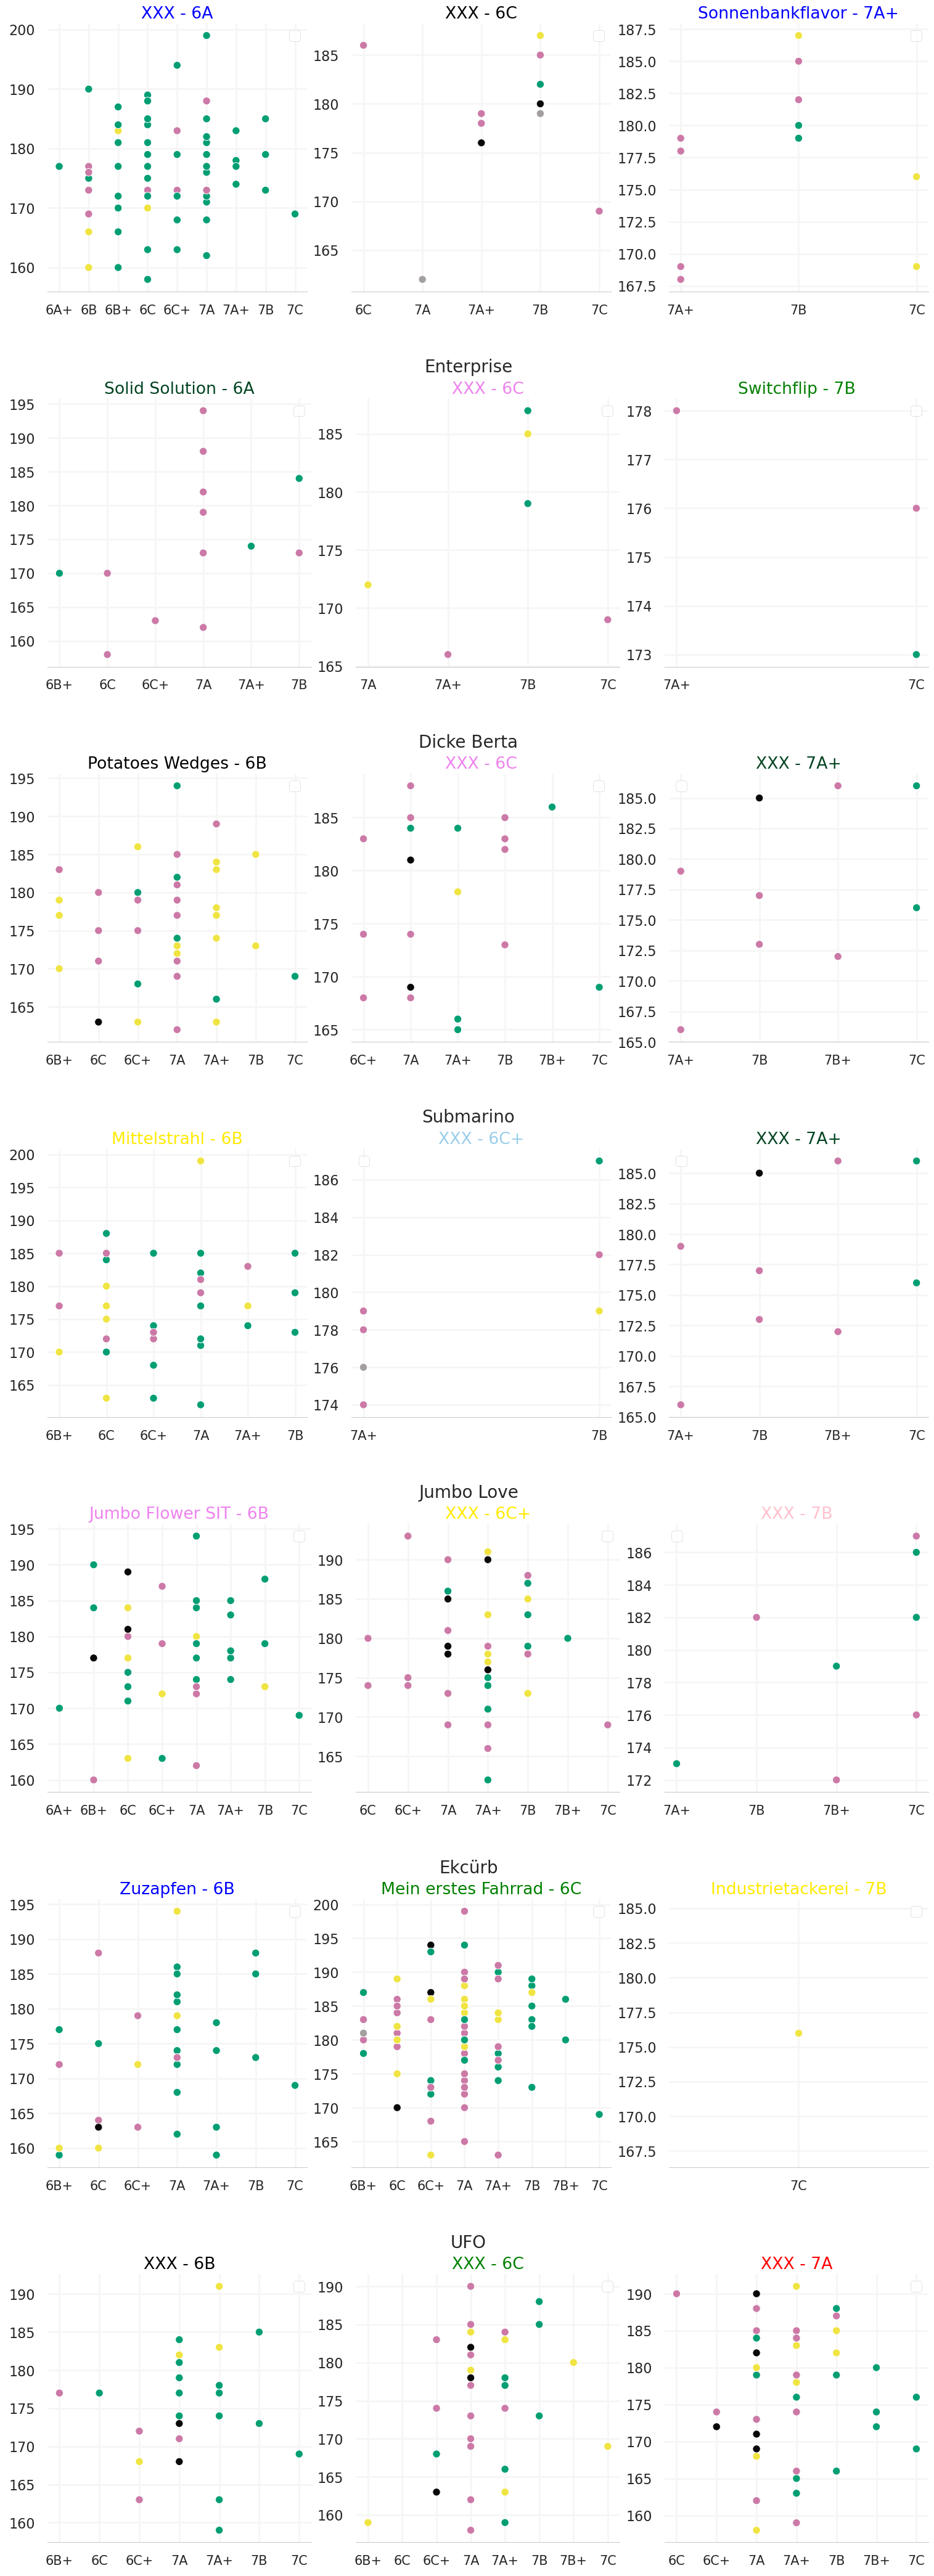

In [33]:
nrows,ncols = len(routes_hrefs)//3,3

#fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

fig = plt.figure(constrained_layout=True, figsize=(5*ncols,6*nrows))

## create nrows subfigs
subfigs = fig.subfigures(nrows=len(routes_hrefs)//3, ncols=1, hspace=0.1)

for i,subfig in enumerate(subfigs):
        
        subfig.suptitle(sectors[i], fontsize=20)
        
        # create 1xncols subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=ncols)
        for j, ax in enumerate(axs):

            df_route = df[df.idx == i*ncols+j]
            df_route = df_route.sort_values(by=["levels"])

            sns.scatterplot(data=df_route, x=df_route.levels, y=df_route.height,
                          hue=df_route.sendtype,# style=df_route.sendtype, #marker=get_marker('🥈')
                            palette=attempt_colors, ax=axs[j], s=80) 

            axs[j].xaxis.set_tick_params(labelsize=15)
            axs[j].legend([])            
            axs[j].set_title(f'{df_route.name.iat[0]} - {df_route.level.iat[0]}', 
                             color=df_route.hold_color.iat[0])
            axs[j].set_xlabel('')
            axs[j].set_ylabel('')
            axs[j].grid(color='#f6f6f6', linestyle='-', linewidth=2)
            sns.despine(left=True)

plt.savefig('xLevel_yHeight_hueAttempts.png')

/home/ella/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ella/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


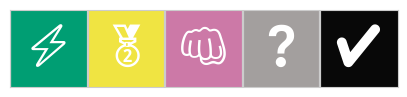

In [34]:
sns.palplot(attempt_colors_hex)
ax = plt.gca()
for i, name in enumerate(attempts):
    ax.text(i-0.35, 0.15, name, c='white', size=30, fontproperties={'family':'Noto Emoji', 'weight':'bold'}) 
    
plt.savefig('hueAttempts.png')